In [1]:
#!kaggle datasets download -d anshtanwar/jellyfish-types

 94%|███████████████████████████████████▋  | 24.0M/25.5M [00:02<00:00, 15.4MB/s]
100%|██████████████████████████████████████| 25.5M/25.5M [00:02<00:00, 9.09MB/s]


# START

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

In [31]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


In [62]:
plt.rcParams["savefig.bbox"] = 'tight'

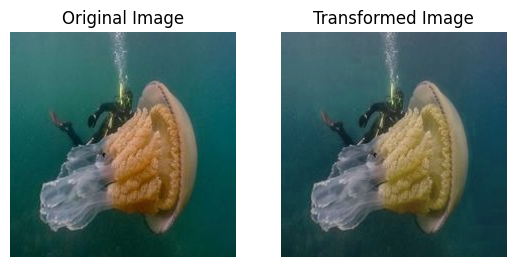

In [63]:
# Load the image
image_path = 'Train_Test_Valid/train/barrel_jellyfish/17.jpg'  # Replace with the path to your image
original_image = Image.open(image_path).convert("RGB")

# Define the transformation
transform = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
# Apply the transformation
transformed_image = transform(original_image)


# Display the original and transformed images
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.title('Transformed Image')
plt.axis('off')


plt.show()

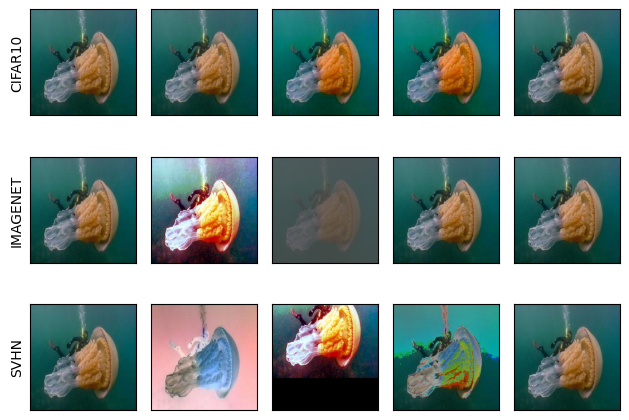

In [71]:
from torchvision.transforms import v2
from helpers import plot
policies = [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
augmenters = [v2.AutoAugment(policy) for policy in policies]
imgs = [
    [augmenter(original_image) for _ in range(4)]
    for augmenter in augmenters
]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot([[original_image] + row for row in imgs], row_title=row_title)

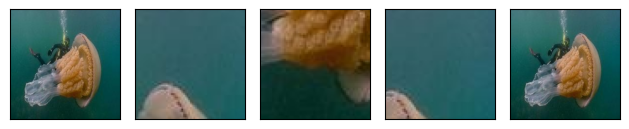

In [81]:
applier = v2.RandomApply(transforms=[v2.RandomCrop(size=(64, 64))], p=0.5)
transformed_imgs = [applier(original_image) for _ in range(4)]
plot([original_image] + transformed_imgs)

# Test GPU

In [76]:
print(torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0), torch.cuda.get_device_name(0))

True 1 0 <torch.cuda.device object at 0x7f1b4c0a14d0> NVIDIA GeForce RTX 3050 Ti Laptop GPU


# Dataset

In [ ]:

'''
def generate_augmented_images(image, num_augmentations=3):
    augmented_images = [train_transform(image) for _ in range(num_augmentations)]
    return augmented_images

# Create a custom dataset class with augmentation
class CustomDatasetWithAugmentation(torch.utils.data.Dataset):
    def __init__(self, root, split='train', transform=None, num_augmentations=5):
        self.dataset = datasets.ImageFolder(root=os.path.join(root, split), transform=transform)
        self.num_augmentations = num_augmentations
        self.classes = self.dataset.classes

    def __getitem__(self, index):
        original_image, label = self.dataset[index]
        augmented_images = generate_augmented_images(original_image, num_augmentations=self.num_augmentations)
        return augmented_images, label

    def __len__(self):
        return len(self.dataset)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, split='train', transform=None):
        self.dataset = datasets.ImageFolder(root=os.path.join(root, split), transform=transform)
        self.classes = self.dataset.classes

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)
        
# Set the root path to the folder containing 'train', 'test', and 'valid' folders
dataset_root = 'Train_Test_Valid'

# Create datasets with and without augmentation
train_dataset_augmented = CustomDatasetWithAugmentation(root=dataset_root, split='train', transform=train_transform)
test_dataset = CustomDataset(root=dataset_root, split='test', transform=val_test_transform)
valid_dataset = CustomDataset(root=dataset_root, split='valid', transform=val_test_transform)

# Create data loaders
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
'''